# Script to read in air-sea CO2 flux data

Script to extract air-sea CO2 flux and separate out abiotic and natural components. For now, the only data available for this are from CESM. Script to date will:
1) Extract historical and future scenario (8.5 MIP) climatologies
2) Calculate monthly climatology over historical period
3) Plot monthly climatology at time series sites (HOT and OSP)

In [1]:
%matplotlib inline

import xarray as xr
import intake

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 1115856 entries:
	> 17 activity_id(s)

	> 24 institution_id(s)

	> 48 source_id(s)

	> 82 experiment_id(s)

	> 163 member_id(s)

	> 35 table_id(s)

	> 1029 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 251 version(s)

	> 7799 time_range(s)

	> 1115856 path(s)

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [3]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 82,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', '1pctCO2-cdr',
                              'amip-future4K', 'amip-m4K', 'a4SST', 'aqua-p4K',
                              'piSST', 'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer', 'hist-nat',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-

#### Searching for specific datasets

Find all the dpCO2 (absolute, natural, and abiotic) at monthly frequency (Omon) from the ocean for the `historical` and `ssp585` experiments. Note that data are currently available only at monthly, not at annual frequency.

Relevant variables: dpco2, dpco2abio, dpco2nat; fgco2, fgco2abio, fgco2nat

Check which models have usable data. For now, don't require models to have *both* `historical` and `ssp585` data because of known issue with CESM, but will add back later. Only use models that have the abiotic and natural data.

In [4]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']: # removing this requirement for the scenario mip b/c of known issue w/ CESM eplained by K. Lindsay, 'ssp585'
    query = dict(experiment_id=experiment_id, table_id='Omon', 
                 variable_id='dpco2abio', grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)
models

['CESM2']

In [5]:
#Find all data for these absolute, abiotic, and natural air-sea CO2 flux data, and take first ensemble member

cat_fgco2nat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                          variable_id='fgco2nat', grid_label='gn', source_id=models, member_id='r1i1p1f1')
cat_fgco2abio = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                           variable_id='fgco2abio', grid_label='gn', source_id=models, member_id='r1i1p1f1')
cat_fgco2 = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                       variable_id='fgco2', grid_label='gn', source_id=models, member_id='r1i1p1f1')

#Look at results for a single variable
cat_fgco2nat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
97784,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,fgco2nat,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
1042792,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,fgco2nat,gn,NaN,v20190730,201501-206412,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...
1042793,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,fgco2nat,gn,NaN,v20190730,206501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...


### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [6]:
dset_dict_fgco2 = cat_fgco2.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})
dset_dict_fgco2abio = cat_fgco2abio.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})
dset_dict_fgco2nat = cat_fgco2nat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2abio' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2abio' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2nat' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2nat' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [7]:
dset_dict_fgco2.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.Omon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn'])

We can access a particular dataset and make a test plot as follows.

In [8]:
# Note that a more suave implementation would index into the key dictionary from above
ds_hist_fgco2 = dset_dict_fgco2['CMIP.NCAR.CESM2.historical.Omon.gn']
ds_hist_fgco2abio = dset_dict_fgco2abio['CMIP.NCAR.CESM2.historical.Omon.gn']
ds_hist_fgco2nat = dset_dict_fgco2nat['CMIP.NCAR.CESM2.historical.Omon.gn']

ds_85_fgco2 = dset_dict_fgco2['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']
ds_85_fgco2abio = dset_dict_fgco2abio['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']
ds_85_fgco2nat = dset_dict_fgco2nat['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']


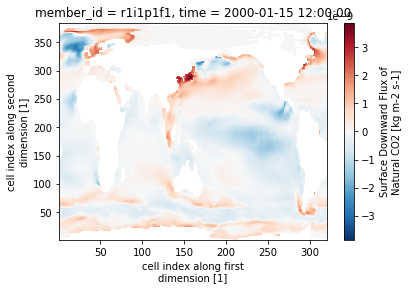

In [9]:
#Initial plotting of example data from 2000
ds_hist_fgco2nat.fgco2nat.sel(time='2000-01-15').plot()


In [10]:
#look at what xarray has in one example dataset
ds_85_fgco2nat

<xarray.Dataset>
Dimensions:    (d2: 2, member_id: 1, nlat: 384, nlon: 320, time: 1032, vertices: 4)
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 2015-01-15 13:00:00 ... 2100-12-15 12:00:00
Dimensions without coordinates: d2, vertices
Data variables:
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bnds  (time, d2) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    fgco2nat   (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 600, 384, 320), meta=

## Make difference maps between fgco2 and fgco2bio

Text(0.5, 1.0, 'January 2100 biotic air-sea co2 flux')

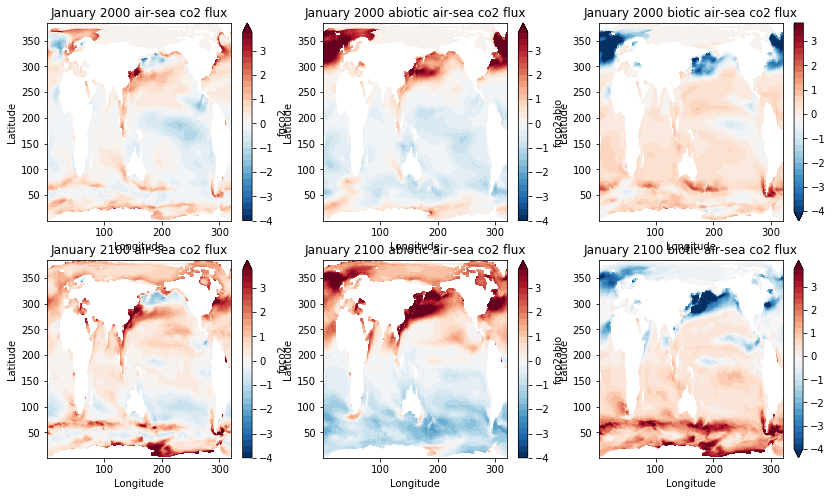

In [51]:
#Set gridding intervals for plotting
levels = np.arange(-4, 4, 0.25)
levels2 = np.arange(-25, 25, 2.5)

fig = plt.figure(figsize=(14, 8))

#Subplot 1 - air-sea co2 flux
ax = fig.add_subplot(2, 3, 1)
(ds_hist_fgco2.fgco2*(10**9)).sel(time='2000-01-15').plot(levels=levels)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('January 2000 air-sea co2 flux')

#Subplot 2 - abiotic air-sea co2 flux
ax2 = fig.add_subplot(2, 3, 2)
(ds_hist_fgco2abio.fgco2abio*(10**9)).sel(time='2000-01-15').plot(levels=levels)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Longitude')
plt.title('January 2000 abiotic air-sea co2 flux')

#Subplot 3 - difference between absolute and abiotic air-sea co2 flux
ax3 = fig.add_subplot(2, 3, 3)
ds_diff = (ds_hist_fgco2.fgco2*(10**9)).sel(time='2000-01-15') - (ds_hist_fgco2abio.fgco2abio*(10**9)).sel(time='2000-01-15')
ds_diff.plot(levels=levels)
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')
plt.title('January 2000 biotic air-sea co2 flux')

#Subplot 4 - future air-sea co2 flux
ax = fig.add_subplot(2, 3, 4)
(ds_85_fgco2.fgco2*(10**9)).sel(time='2100-01-15').plot(levels=levels)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('January 2100 air-sea co2 flux')

#Subplot 5 - future abiotic air-sea co2 flux
ax2 = fig.add_subplot(2, 3, 5)
(ds_85_fgco2abio.fgco2abio*(10**9)).sel(time='2100-01-15').plot(levels=levels)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Longitude')
plt.title('January 2100 abiotic air-sea co2 flux')

#Subplot 6 - future difference between absolute and abiotic air-sea co2 flux
ax3 = fig.add_subplot(2, 3, 6)
ds_diff = (ds_85_fgco2.fgco2*(10**9)).sel(time='2100-01-15') - (ds_85_fgco2abio.fgco2abio*(10**9)).sel(time='2100-01-15')
ds_diff.plot(levels=levels)
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')
plt.title('January 2100 biotic air-sea co2 flux')

## Historical 12-month climatology

In [45]:
#merge datasets before calculating climatology
ds_hist_all = xr.merge([ds_hist_fgco2, ds_hist_fgco2nat, ds_hist_fgco2abio])

In [46]:
#Calculate differenced properties before taking climatology
hist_fgco2bio = ds_hist_all.fgco2 - ds_hist_all.fgco2abio
ds_hist_all['fgco2bio'] = hist_fgco2bio

hist_fgco2ant = ds_hist_all.fgco2 - ds_hist_all.fgco2nat
ds_hist_all['fgco2ant'] = hist_fgco2ant

In [48]:
#Calculate climatologies and StDevs
clim_m_hist_all = ds_hist_all.groupby('time.month').mean('time')
clim_std_hist_all = ds_hist_all.groupby('time.month').std('time')

In [50]:
#Look at the xarray info for one example climatology
clim_m_hist_all

<xarray.Dataset>
Dimensions:    (member_id: 1, month: 12, nlat: 384, nlon: 320, vertices: 4)
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: vertices
Data variables:
    lat        (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lon_bnds   (month, nlat, nlon, vertices) float32 dask.array<chunksize=(1, 384, 320, 4), meta=np.ndarray>
    lon        (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lat_bnds   (month, nlat, nlon, vertices) float32 dask.array<chunksize=(1, 384, 320, 4), meta=np.ndarray>
    fgco2      (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
    fgco2nat   (month, member_id, nlat, nlon) float32 dask.

In [52]:
#Function from Riley Brady to find the i,j coordinates of a fixed lat lon point on a curvilinear grid
def find_indices(xgrid, ygrid, xpoint, ypoint):
    """Returns the i, j index for a latitude/longitude point on a grid.
    .. note::
        Longitude and latitude points (``xpoint``/``ypoint``) should be in the same
        range as the grid itself (e.g., if the longitude grid is 0-360, should be
        200 instead of -160).
    Args:
        xgrid (array_like): Longitude meshgrid (shape `M`, `N`)
        ygrid (array_like): Latitude meshgrid (shape `M`, `N`)
        xpoint (int or double): Longitude of point searching for on grid.
        ypoint (int or double): Latitude of point searching for on grid.
    Returns:
        i, j (int):
            Keys for the inputted grid that lead to the lat/lon point the user is
            seeking.
    Examples:
        >>> import esmtools as et
        >>> import numpy as np
        >>> x = np.linspace(0, 360, 37)
        >>> y = np.linspace(-90, 90, 19)
        >>> xx, yy = np.meshgrid(x, y)
        >>> xp = 20
        >>> yp = -20
        >>> i, j = et.spatial.find_indices(xx, yy, xp, yp)
        >>> print(xx[i, j])
        20.0
        >>> print(yy[i, j])
        -20.0
    """
    dx = xgrid - xpoint
    dy = ygrid - ypoint
    reduced_grid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reduced_grid)
    i, j = np.unravel_index(min_ix, reduced_grid.shape)
    return i, j

In [54]:
# Get indices for time series sites of choice - note that output is lat lon but input is ordered lon lat
HOT = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 360 - 158, 22.75)
OSP = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 360 - 150, 50)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/ar

Text(0.5, 0, 'Month')

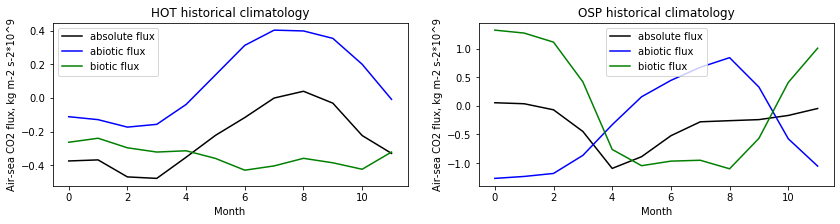

In [58]:
#Plot historical climatology at fixed time series points

fig = plt.figure(figsize=(14, 3))

ax1 = fig.add_subplot(1, 2, 1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

plt.plot(-clim_m_hist_all.fgco2.sel(nlat=HOT[0],nlon=HOT[1])*10**9,'k',label='absolute flux')
plt.plot(-clim_m_hist_all.fgco2abio.sel(nlat=HOT[0],nlon=HOT[1])*10**9,'b',label='abiotic flux')
plt.plot(-clim_m_hist_all.fgco2bio.sel(nlat=HOT[0],nlon=HOT[1])*10**9,'g',label='biotic flux')
plt.legend()
plt.title('HOT historical climatology')
plt.ylabel('Air-sea CO2 flux, kg m-2 s-2*10^9')
plt.xlabel('Month')

ax2 = fig.add_subplot(1, 2, 2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)

plt.plot(-clim_m_hist_all.fgco2.sel(nlat=OSP[0],nlon=OSP[1])*10**9,'k',label='absolute flux')
plt.plot(-clim_m_hist_all.fgco2abio.sel(nlat=OSP[0],nlon=OSP[1])*10**9,'b',label='abiotic flux')
plt.plot(-clim_m_hist_all.fgco2bio.sel(nlat=OSP[0],nlon=OSP[1])*10**9,'g',label='biotic flux')
plt.legend()
plt.title('OSP historical climatology')
plt.ylabel('Air-sea CO2 flux, kg m-2 s-2*10^9')
plt.xlabel('Month')